# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Подготовка данных

In [3]:
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [4]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Видим, что почти в каждом столбце есть пропуски, посмотрим, сколько данных останется после удаления пропусков.

In [5]:
for df in [gold_recovery_full, gold_recovery_test, gold_recovery_train]:
    df.dropna(inplace=True)       

gold_recovery_full.shape[0], gold_recovery_test.shape[0], gold_recovery_train.shape[0]

(16094, 5383, 11017)

Мы удалили около 30% строк, однако осталось 16 000 строк, этих данных должно хватить для обучения моделей. 

Посмотрим, какие данные отсутствуют в тестовой выборке

In [6]:
gold_recovery_train.columns[~gold_recovery_train.columns.isin(gold_recovery_test.columns)]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

В тестовой выборке недоступны характеристики продукта после флотации, первой и второй очисток и финальные характеристики.

Посчитаем коэффициент восстановления.

In [7]:
C = gold_recovery_train['rougher.output.concentrate_au']
F = gold_recovery_train['rougher.input.feed_au']
T = gold_recovery_train['rougher.output.tail_au']

my_recovery = C * (F - T) / (F * (C - T)) * 100
mean_absolute_error(gold_recovery_train['rougher.output.recovery'], my_recovery)

9.460144184559453e-15

Коэффициент восстановления посчитан правильно.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

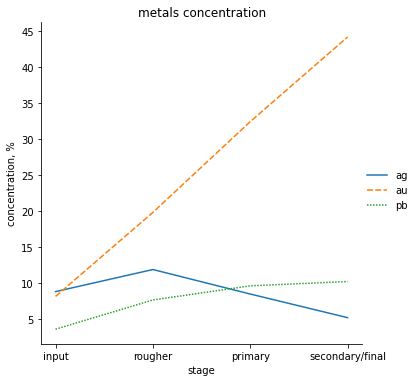

In [8]:
df_temp = pd.DataFrame(((df['rougher.input.feed_ag'].mean(), 
                         df['rougher.output.concentrate_ag'].mean(),
                         df['primary_cleaner.output.concentrate_ag'].mean(),
                         df['final.output.concentrate_ag'].mean()), 
                        
                        (df['rougher.input.feed_au'].mean(), 
                         df['rougher.output.concentrate_au'].mean(),
                         df['primary_cleaner.output.concentrate_au'].mean(),
                         df['final.output.concentrate_au'].mean()),
                        
                        (df['rougher.input.feed_pb'].mean(), 
                         df['rougher.output.concentrate_pb'].mean(),
                         df['primary_cleaner.output.concentrate_pb'].mean(),
                         df['final.output.concentrate_pb'].mean()))).T

df_temp.columns = ['ag', 'au', 'pb']
df_temp.index = ['input', 'rougher', 'primary', 'secondary/final']

sns.relplot(data=df_temp, kind="line")
plt.title('metals concentration')
plt.ylabel('concentration, %')
plt.xlabel('stage');

Концентрацию золота увеличивается, концентрация серебра сначала растет, потом падает, концентрация свинца растет, но слабо.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

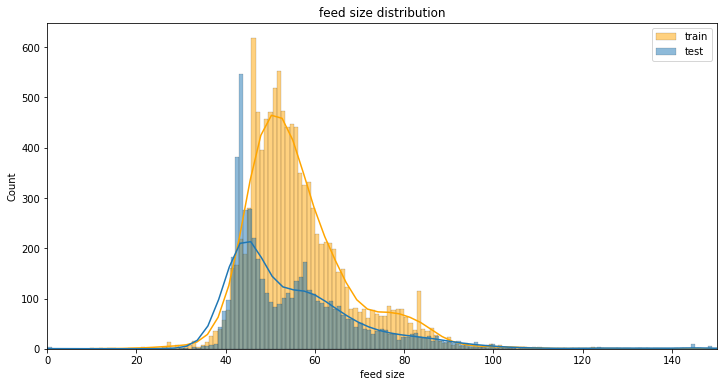

In [9]:
plt.figure(figsize=(12,6))
sns.histplot(gold_recovery_train['rougher.input.feed_size'], bins=500,  color="orange", label="train", kde=True)
sns.histplot(gold_recovery_test['rougher.input.feed_size'], bins=500, label="test", kde=True)
plt.xlim((0, 150))
plt.title('feed size distribution')
plt.xlabel('feed size')
plt.legend() 
plt.show()

Различия в распределениях в данной задаче несущественны.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

<AxesSubplot:ylabel='Count'>

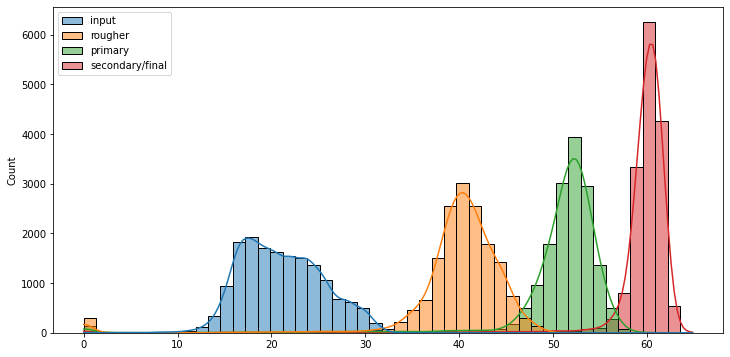

In [10]:
df_concentration = pd.DataFrame()

df_concentration['input'] = gold_recovery_full['rougher.input.feed_ag'] + \
                            gold_recovery_full['rougher.input.feed_au'] + \
                            gold_recovery_full['rougher.input.feed_pb'] 

df_concentration['rougher'] = gold_recovery_full['rougher.output.concentrate_ag'] + \
                              gold_recovery_full['rougher.output.concentrate_au'] + \
                              gold_recovery_full['rougher.output.concentrate_pb']

df_concentration['primary'] = gold_recovery_full['primary_cleaner.output.concentrate_ag'] + \
                              gold_recovery_full['primary_cleaner.output.concentrate_au'] + \
                              gold_recovery_full['primary_cleaner.output.concentrate_pb'] 

df_concentration['secondary/final'] = gold_recovery_full['final.output.concentrate_ag'] + \
                                      gold_recovery_full['final.output.concentrate_au'] + \
                                      gold_recovery_full['final.output.concentrate_pb'] 

plt.figure(figsize=(12,6))
sns.histplot(df_concentration, kde=True)

Видим выбросы с значениями близкими к нулю. Удалим их.

In [11]:
inds = df_concentration[(df_concentration['input']<1) | \
                 (df_concentration['rougher']<1) | \
                 (df_concentration['primary']<1) | \
                 (df_concentration['secondary/final']<1)].index

print('Количество выбросов:', inds.shape[0])

gold_recovery_full.drop(index = inds, inplace=True)
gold_recovery_test.drop(index = gold_recovery_test.index[gold_recovery_test.index.isin(inds)], inplace=True)
gold_recovery_train.drop(index = gold_recovery_train.index[gold_recovery_train.index.isin(inds)], inplace=True)

Количество выбросов: 479


# 3. Модель

Нужно спрогнозировать две величины:
- эффективность обогащения чернового концентрата после флотации;
- эффективность обогащения финального концентрата.

Напишем функцию для вычисления нашей метрики - sMAPE.

In [12]:
def smape_function(true, predicted):
    
#     smape = abs(true - predicted) / (abs(true) + abs(predicted)) / 2 
    smape = abs(true - predicted) / (abs(true) + abs(predicted)) * 2  # NEW
    smape = smape.mean() * 100
    
    return smape

smape_score = make_scorer(smape_function)

В ходе обучения будем работать с полным датасетом и сами поделим его на тренировочную и тестовую части.

In [13]:
def models_smape(models, X, y):
    
    smape = []
    
    for model in models:
        model.fit(X_train, y_train)
        smape.append(cross_val_score(model, X, y, scoring=smape_score).mean())
        
    return smape

Спрогнозируем эффективность обогащения чернового концентрата после флотации, для этого отберем нужные признаки.

In [14]:
feature_cols = [
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',

    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level',
]
target_col = 'rougher.output.recovery'

X = gold_recovery_full[feature_cols]
y = gold_recovery_full[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [15]:
models_rougher = [
          LinearRegression(), 
          AdaBoostRegressor(random_state=42, n_estimators=10), 
          LinearSVR(random_state=42)
         ]

models_smape(models_rougher, X_train, y_train)

[4.314670614135612, 4.573231288735653, 6.07832467869501]

Моделью для предсказания эффективности обогащения чернового концентрата после флотации выберем линейную регрессию, так как она показала лучший результат - 4,3%.

Проверим модель на тестовой выборке.

In [16]:
smape_rougher = smape_score(models_rougher[0], X_test, y_test)
print(f'rougher sMAPE: {smape_rougher:0.3}%')

mean_data = pd.DataFrame(np.zeros(shape=(y_test.shape[0]))).replace(0, y_test.mean())
smape_rougher_mean = smape_function(y_test.reset_index(drop=True), mean_data[0])
print(f'rougher mean sMAPE: {smape_rougher_mean:0.3}%')

rougher sMAPE: 4.36%
rougher mean sMAPE: 6.26%


Спрогнозируем эффективность обогащения финального концентрата. В качестве доступных характеристик примем колонки из тестового датасета.

In [17]:
feature_cols = gold_recovery_test.columns.drop(['date'])
target_col = 'final.output.recovery'

X = gold_recovery_full[feature_cols]
y = gold_recovery_full[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [18]:
models_final = [
          LinearRegression(), 
          AdaBoostRegressor(random_state=42, n_estimators=10), 
          LinearSVR(random_state=42)
         ]

models_smape(models_final, X_train, y_train)

[6.8838097463531085, 7.272858572467399, 9.487144816970675]

Моделью для предсказания эффективности обогащения финального концентрата выберем линейную регрессию, так как снова она показала лучший результат - 6,9%.

Проверим модель на тестовой выборке.

In [19]:
smape_final = smape_score(models_final[0], X_test, y_test)
print(f'final sMAPE: {smape_final:0.3}%')

mean_data = pd.DataFrame(np.zeros(shape=(y_test.shape[0]))).replace(0, y_test.mean())
smape_final_mean = smape_function(y_test.reset_index(drop=True), mean_data[0])
print(f'final mean sMAPE: {smape_final_mean:0.3}%')

final sMAPE: 6.86%
final mean sMAPE: 8.47%


Посчитаем итоговую метрику.

In [20]:
smape_total = 0.25*smape_rougher + 0.75*smape_final
smape_total_mean = 0.25*smape_rougher_mean + 0.75*smape_final_mean
print(f'total sMAPE: {smape_total:0.3}%')
print(f'total mean sMAPE: {smape_total_mean:0.3}%')

total sMAPE: 6.23%
total mean sMAPE: 7.91%


# Вывод

В данной работе мы:
- изучили и подготовили данные: удалили пропуски, проверили правильность расчетов;
- проанализировали изменение концентрации металлов на разных этапах, изучили распределения размеров гранул сырья, обнаружили выбросы с концентрацией металлов около нуля;
- написали функцию для вычисления своей метрики sMAPE, обучили различные модели и выбрали лучшие, посчитали итоговую метрику.

Среди всех моделей в обеих задачах лучше всего себя показала линейная регрессия с качеством 4,3% и 6,8%. Итоговая метрика равна 6,2%.  